In [1]:
import math
import numpy as np
import nbimporter
import matplotlib.pyplot as plt
import copy

# 外皮情報LV1からLV2へのコンバート

## 1. 外皮簡易法＋用途別床面積

- 当該住戸の外皮の部位の面積等を用いずに簡易熱負荷計算を実施する場合には、部位の面積および長さを、「平成28年省エネルギー基準に準拠したエネルギー消費性能の評価に関する技術情報（住宅）」２．エネルギー消費性能の算定方法　2.2　算定方法　第三章　 暖冷房負荷と外皮性能　	第二節　外皮性能　9.当該住戸の外皮の部位の面積等を用いずに外皮性能を評価する方法　に示された標準住戸（以下、「簡易外皮入力モデル」）における部位の面積および長さ等より推定する。
- 屋根・天井、外壁、床の構成は、入力値である部位種別の熱貫流率をもとに、部位のU値から壁体構成を決定する方法により決定する。
- 土間床等の外周部の線熱貫流率については、簡易熱負荷計算での扱いに従う
- 開口部の日射熱取得率および外部日除けの取得日射熱補正係数は、それぞれ、季節別に、垂直面日射熱取得率および取得日射熱補正係数の入力値もしくは規定値を使用する。この場合、簡易熱負荷計算においては、開口部の入射角特性および外部日除けは考慮しない。
- その他は、外皮性能計算プログラムの入力情報に用途別床面積を追加したものと同様に求める。

## I. 関数

### 1. 規模係数

$$r_{size} = \frac{ A_A }{ A_{S,A} }$$

$r_{size}$: 規模係数  
$A_{A}$: 床面積の合計, m<sup>2</sup>  
$A_{S,A}$: 簡易モデル住宅の床面積の合計, m<sup>2</sup>  

$A_{S,A}$は90.0(m<sup>2</sup>)とする。

In [2]:
def get_size_ratio(a_a):
    
    a_s_a = 90.0
    
    return a_a / a_s_a

### 2. 主開口方位

主開口方位は南西とする。

In [3]:
def get_direction(angle):
    
    if angle == '0':
        return 'sw'
    elif angle == '90':
        return 'nw'
    elif angle == '180':
        return 'ne'
    elif angle == '270':
        return 'se'
    else:
        return angle

### 3. 一般部位

| 番号 | 部位の種類 | 隣接空間の種類 | 方位 | 床断熱住戸<br>浴室床断熱<br>面積(m2) | 床断熱住戸<br>浴室基礎断熱<br>面積(m2) | 床断熱住戸<br>浴室床なし<br>面積(m2) | 基礎断熱住戸<br>面積(m2) | 熱貫流率(W/m2K) |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 屋根又は天井 | 外気             |  上面 | 50.85 | 50.85 | 50.85 | 50.85 | $U_{roof}$        |
| 2 | 壁           | 外気             |   0度 | 30.47 | 30.47 | 30.47 | 30.47 | $U_{wall}$        |
| 3 | 壁           | 外気             |  90度 | 22.37 | 22.37 | 22.37 | 22.37 | $U_{wall}$        |
| 4 | 壁           | 外気             | 180度 | 47.92 | 47.92 | 47.92 | 47.92 | $U_{wall}$        |
| 5 | 壁           | 外気             | 270度 | 22.28 | 22.28 | 22.28 | 22.28 | $U_{wall}$        |
| 6 | 床           | 外気に通じる床裏 |  下面 | 45.05 | 45.05 | 48.36 |  0.00 | $U_{floor,other}$ |
| 7 | 床           | 外気に通じる床裏 |  下面 |  3.31 |  0.00 |  0.00 |  0.00 | $U_{floor,bath}$  |

面積は表の値に規模係数を乗じた値とする。

In [4]:
def get_general_parts(total_floor_area, house_type,
                      u_value_roof, u_value_wall, u_value_floor_other = None, u_value_floor_bathroom = None, **kwargs):

    table = [
        [1, 'ceiling', 'outdoor'   , 'top',      {'f_f' : 50.85, 'f_b' : 50.85, 'f_n' : 50.85, 'b' : 50.85}, u_value_roof           ],
        [2, 'wall',    'outdoor'   , '0',        {'f_f' : 30.47, 'f_b' : 30.47, 'f_n' : 30.47, 'b' : 30.47}, u_value_wall           ],
        [3, 'wall',    'outdoor'   , '90',       {'f_f' : 22.37, 'f_b' : 22.37, 'f_n' : 22.37, 'b' : 22.37}, u_value_wall           ],
        [4, 'wall',    'outdoor'   , '180',      {'f_f' : 47.92, 'f_b' : 47.92, 'f_n' : 47.92, 'b' : 47.92}, u_value_wall           ],
        [5, 'wall',    'outdoor'   , '270',      {'f_f' : 22.28, 'f_b' : 22.28, 'f_n' : 22.28, 'b' : 22.28}, u_value_wall           ],
        [6, 'floor',   'underfloor', 'downward', {'f_f' : 45.05, 'f_b' : 45.05, 'f_n' : 48.36, 'b' :  0.00}, u_value_floor_other    ],
        [7, 'floor',   'underfloor', 'downward', {'f_f' :  3.31, 'f_b' :  0.00, 'f_n' :  0.00, 'b' :  0.00}, u_value_floor_bathroom ],
    ]

    parts = []
    
    for row in table:
        
        if row[4][house_type] > 0.0:
            
            parts.append({
                'name'              : 'simple_general_part' + str(row[0]),
                'evlp_type'         : row[1],
                'next_space'        : row[2],
                'direction'         : get_direction(row[3]),
                'area'              : row[4][house_type] * get_size_ratio(total_floor_area),
                'structure'         : 'wood',
                'input_method_wall' : 'u_value',
                'u_value'           : row[5],
                'is_sunshade_input' : False
            })
    
    return parts

example

In [5]:
get_general_parts(
    total_floor_area=120.0,
    house_type='f_f',
    u_value_roof= 7.7,
    u_value_wall= 6.67,
    u_value_floor_other=5.27,
    u_value_floor_bathroom=5.27,
)

[{'name': 'simple_general_part1',
  'evlp_type': 'ceiling',
  'next_space': 'outdoor',
  'direction': 'top',
  'area': 67.8,
  'structure': 'wood',
  'input_method_wall': 'u_value',
  'u_value': 7.7,
  'is_sunshade_input': False},
 {'name': 'simple_general_part2',
  'evlp_type': 'wall',
  'next_space': 'outdoor',
  'direction': 'sw',
  'area': 40.626666666666665,
  'structure': 'wood',
  'input_method_wall': 'u_value',
  'u_value': 6.67,
  'is_sunshade_input': False},
 {'name': 'simple_general_part3',
  'evlp_type': 'wall',
  'next_space': 'outdoor',
  'direction': 'nw',
  'area': 29.826666666666668,
  'structure': 'wood',
  'input_method_wall': 'u_value',
  'u_value': 6.67,
  'is_sunshade_input': False},
 {'name': 'simple_general_part4',
  'evlp_type': 'wall',
  'next_space': 'outdoor',
  'direction': 'ne',
  'area': 63.89333333333333,
  'structure': 'wood',
  'input_method_wall': 'u_value',
  'u_value': 6.67,
  'is_sunshade_input': False},
 {'name': 'simple_general_part5',
  'evlp_ty

### 4. 大部分がガラスで構成される窓等の開口部

#### 1) 壁面からの日除けの張り出し寸法

取得日射熱補正係数を指定する場合

$$
z_H = b_H \frac{c_H y_1 + y_2}{ \frac{f_H}{0.01} - a_H }
$$

ただし、$f_H$が0.72を超える場合は$f_H=0.72$とする。また、$z_H$が5.0を超える場合は$z_H=5.0$とする。

$$
z_C = b_C \frac{c_C y_1 + y_2}{ \frac{f_C}{0.01} - a_C }
$$

ただし、$f_H$が0.93を超える場合は$f_C=0.93$とする。また、$z_C$が5.0を超える場合は$z_C=5.0$とする。

取得日射熱補正係数を指定しない場合

$$ z_H = \frac{ ( y_1 + y_2 ) }{ l_{H,2} } $$

$$z_C=0$$

$z_H$：暖房期の壁面から日除けの張り出し寸法, m  
$z_C$：冷房期の壁面から日除けの張り出し寸法, m  
$f_H$: 暖房期の取得日射熱補正係数  
$f_C$: 冷房期の取得日射熱補正係数  
$y_{1}$：日除け下端から窓上端までの垂直方向の距離, m  
$y_{2}$：窓の開口高さ, m  

$$y_1=0$$

$$y_2=1.1$$

$$l_{H,2}=\frac{1}{0.3}$$

| 季節 | 地域区分 | 方位 | a | b | c |
|:---:|:---:|:---:|:---:|:---:|:---:|
| 暖房期 | 1地域～7地域 | 南東(SE) | 5 | 20 | 3 |
| 暖房期 | 1地域～7地域 | 南西(SW) | 5 | 20 | 3 |
| 暖房期 | 1地域～7地域 | 北西(NW) | 10 | 15 | 2 |
| 暖房期 | 1地域～7地域 | 北東(NE) | 10 | 15 | 2 |

| 季節 | 地域区分 | 方位 | a | b | c |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| 冷房期 | 1地域～7地域 | 南東(SE) | 16 | 24 | 2 |
| 冷房期 | 1地域～7地域 | 南西(SW) | 16 | 24 | 2 |
| 冷房期 | 1地域～7地域 | 北西(NW) | 16 | 24 | 2 |
| 冷房期 | 1地域～7地域 | 北東(NE) | 16 | 24 | 2 |
| 冷房期 | 8地域 | 南東(SE) | 16 | 19 | 2 |
| 冷房期 | 8地域 | 南西(SW) | 16 | 19 | 2 |
| 冷房期 | 8地域 | 北西(NW) | 16 | 24 | 2 |
| 冷房期 | 8地域 | 北東(NE) | 16 | 24 | 2 |

In [6]:
def get_heating_overhang_width(is_f_value_input, region, direction, y1, y2, f_value=None):

    if is_f_value_input:
        
        if region == 8:
            raise ValueError('8地域では、暖房期の日除けの出は定義されていません')    
        
        
        if region <= 7:
            a, b, c = {
                'se': ( 5, 20, 3),
                'sw': ( 5, 20, 3),
                'nw': (10, 15, 2),
                'ne': (10, 15, 2)
            }[direction]
        elif region == 8:
            raise ValueError('z_Hを取得する関数で地域が8地域を指定されました。')
        else:
            raise ValueError('z_Hを取得する関数でregionに不正な値が指定されました。')
        
        _f = min(f_value, 0.72)
        
        if ( ( _f / 0.01 ) - a) <= 0: 
            return 5.0
        else:
            return min( ( b * ( c * y1 + y2) ) / ( ( _f / 0.01 ) - a ), 5.0 )

    else:
        
        l_h_2 = 1 / 0.3
        
        return ( y1 + y2 ) / l_h_2        

In [7]:
def get_cooling_overhang_width(is_f_value_input, region, direction, y1, y2, f_value=None):

    if is_f_value_input:
        
        if region <= 7:
            a, b, c = {
                'se': (16, 24, 2),
                'sw': (16, 24, 2),
                'nw': (16, 24, 2),
                'ne': (16, 24, 2)
            }[direction]
        elif region == 8:
            a, b, c = {
                'se': (16, 19, 2),
                'sw': (16, 19, 2),
                'nw': (16, 24, 2),
                'ne': (16, 24, 2)
            }[direction]
        else:
            raise ValueError('z_Cを取得する関数でregionに不正な値が指定されました。')
            
        _f = min(f_value, 0.93)
        
        if ( ( _f / 0.01 ) - a) <= 0: 
            return 5.0
        else:
            return min( ( b * ( c * y1 + y2) ) / ( ( _f / 0.01 ) - a ), 5.0 )
    
    else:
        
        return 0.0

example

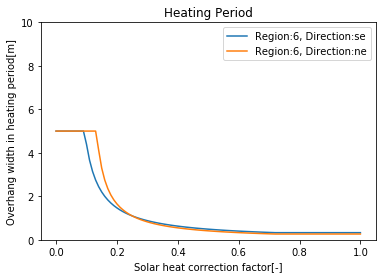

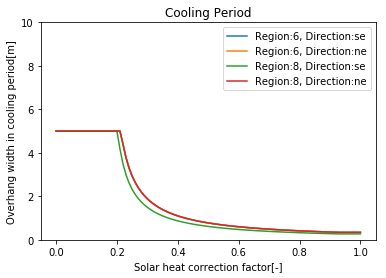

In [8]:
# 取得日射熱補正係数の配列を用意
xs = np.arange( 0.0, 1.01, 0.01 )

windows = [
    {'region': 6, 'direction': 'se'},
    {'region': 6, 'direction': 'ne'},
    {'region': 8, 'direction': 'se'},
    {'region': 8, 'direction': 'ne'}
]

y1, y2 = 0.0, 1.1

# 暖房期の出巾のグラフ描画 
for window in windows:
    if window['region'] >= 8:
        continue
    else:
        z_h = [get_heating_overhang_width(is_f_value_input=True, region=window['region'], direction=window['direction'],
                                          y1=y1, y2=y2, f_value=f) for f in xs]
        label =  'Region:' + str(window['region']) + ', Direction:' + window['direction']
        plt.plot(xs, z_h, label = label)
    
plt.title('Heating Period')
plt.xlabel('Solar heat correction factor[-]')
plt.ylabel('Overhang width in heating period[m]')
plt.ylim(0,10)
plt.legend()
plt.show()

# 冷房期の出巾のグラフ描画 
for window in windows:
    z_c = [get_cooling_overhang_width(is_f_value_input=True, region=window['region'], direction=window['direction'],
                                      y1=y1, y2=y2, f_value=f) for f in xs]
    label =  'Region:' + str(window['region']) + ', Direction:' + window['direction']
    plt.plot(xs, z_c, label = label)
    
plt.title('Cooling Period')
plt.xlabel('Solar heat correction factor[-]')
plt.ylabel('Overhang width in cooling period[m]')
plt.ylim(0,10)
plt.legend()
plt.show()

1地域～7地域

$$z=\frac{z_H + z_C}{2}$$

8地域

$$ z = z_C $$

$z$：壁面から日除けの張り出し寸法, m  

In [9]:
def get_y1_y2_z(is_f_value_input, region, direction, f_value_h=None, f_value_c=None):
    y1, y2 = 0.0, 1.1 
    if region == 8:
        z_C = get_cooling_overhang_width(is_f_value_input, region, direction, y1, y2, f_value_c)
        return y1, y2, z_C
    else:
        z_H = get_heating_overhang_width(is_f_value_input, region, direction, y1, y2, f_value_h)
        z_C = get_cooling_overhang_width(is_f_value_input, region, direction, y1, y2, f_value_c)
        return y1, y2, ( z_H + z_C ) / 2

#### 2) 種類・隣接空間の種類・方位・面積

| 番号 | 隣接空間の種類 | 方位 | 面積(m2) | 熱貫流率(W/m2K) | 暖房期の垂直面日射熱取得率 | 冷房期の垂直面日射熱取得率 |
| --- | --- | --- | --- | --- | --- | --- |
| 1 | 外気 |   0度 | 22.69 | $U_{wall}$ | $\eta_{d,H}$ | $\eta_{d,C}$ |
| 2 | 外気 |  90度 |  2.38 | $U_{wall}$ | $\eta_{d,H}$ | $\eta_{d,C}$ |
| 3 | 外気 | 180度 |  3.63 | $U_{wall}$ | $\eta_{d,H}$ | $\eta_{d,C}$ |
| 4 | 外気 | 270度 |  4.37 | $U_{wall}$ | $\eta_{d,H}$ | $\eta_{d,C}$ |

面積は表の値に規模係数を乗じた値とする。

$$ \eta_d = \frac{ ( \eta_{d,H} + \eta_{d,C} ) }{ 2 } $$

$ \eta_{d,H} $：暖房期の垂直面日射熱取得率  
$ \eta_{d,C} $：冷房期の垂直面日射熱取得率  
$ \eta_d $：垂直面日射熱取得率  

In [10]:
def get_eta_d(eta_value_d_h, eta_value_d_c):
    return ( eta_value_d_h + eta_value_d_c ) / 2

In [11]:
def get_window_parts(total_floor_area, region,
                     u_value_window, eta_d_value_window_h, eta_d_value_window_c,
                     is_f_value_input, f_value_h, f_value_c, **kwargs ):

    table = [
        [1, 'outdoor' ,   '0', 22.69, u_value_window, eta_d_value_window_h, eta_d_value_window_c],
        [2, 'outdoor' ,  '90',  2.38, u_value_window, eta_d_value_window_h, eta_d_value_window_c],
        [3, 'outdoor' , '180',  3.63, u_value_window, eta_d_value_window_h, eta_d_value_window_c],
        [4, 'outdoor' , '270',  4.37, u_value_window, eta_d_value_window_h, eta_d_value_window_c],
    ]
    
    parts = []
    
    for row in table:
    
        direction = get_direction(row[2])
        y1, y2, z = get_y1_y2_z(is_f_value_input, region, direction, f_value_h, f_value_c)

        parts.append({
            'name'             : 'simple_window_part' + str(row[0]),
            'next_space'       : row[1],
            'direction'        : direction,
            'area'             : row[3] * get_size_ratio(total_floor_area),
            'window_type'      : 'Single',
            'eta_input_method' : 'InputValue',
            'u_value'          : row[4],
            'eta_value'        : get_eta_d(row[5], row[6]),
            'glass_type'       : 't_single',
            'y1'               : y1,
            'y2'               : y2,
            'z'                : z,
            'IsSunshadeInput'  : is_f_value_input,
        })

    return parts

#### Example

In [12]:
get_window_parts(
    total_floor_area = 120.0,
    region = 6,
    u_value_window = 3.49,
    eta_d_value_window_h = 0.51, 
    eta_d_value_window_c = 0.51,       
    is_f_value_input = True, 
    f_value_h = 0.7,
    f_value_c = 0.9
)

[{'name': 'simple_window_part1',
  'next_space': 'outdoor',
  'direction': 'sw',
  'area': 30.253333333333334,
  'window_type': 'Single',
  'eta_input_method': 'InputValue',
  'u_value': 3.49,
  'eta_value': 0.51,
  'glass_type': 't_single',
  'y1': 0.0,
  'y2': 1.1,
  'z': 0.34760914760914763,
  'IsSunshadeInput': True},
 {'name': 'simple_window_part2',
  'next_space': 'outdoor',
  'direction': 'nw',
  'area': 3.173333333333333,
  'window_type': 'Single',
  'eta_input_method': 'InputValue',
  'u_value': 3.49,
  'eta_value': 0.51,
  'glass_type': 't_single',
  'y1': 0.0,
  'y2': 1.1,
  'z': 0.3158783783783784,
  'IsSunshadeInput': True},
 {'name': 'simple_window_part3',
  'next_space': 'outdoor',
  'direction': 'ne',
  'area': 4.84,
  'window_type': 'Single',
  'eta_input_method': 'InputValue',
  'u_value': 3.49,
  'eta_value': 0.51,
  'glass_type': 't_single',
  'y1': 0.0,
  'y2': 1.1,
  'z': 0.3158783783783784,
  'IsSunshadeInput': True},
 {'name': 'simple_window_part4',
  'next_spac

### 5) Doors / 開口部の不透明部位

#### Outline

- 開口部の不透明部位（ドア等）の情報を設定する。
- 簡易外皮入力モデルにおける開口部の不透明部位の面積は、方位から決定する。

#### Input

参照：InputDataDefinition.ipynb

#### Output

```
{
    'Name'
    'Direction'
    'Area'
    'U'
    'IsSunshadeInput'
}
```


参照：InputDataDefinition.ipynb

#### Function

In [13]:
def make_door(name, nextspace, direction, area, TotalFloorArea, UDoor):
    return {
        'name'           : name,
        'nextspace'      : nextspace,
        'direction'      : direction,
        'area'           : area * get_size_ratio(TotalFloorArea),
        'U'              : UDoor,
        'IsSunshadeInput': False
    }

In [14]:
def convert_door(TotalFloorArea, UDoor, **kwargs):
    
    #簡易外皮入力モデルにおける開口部の不透明部位のリストを作成
    standard_parts = [
        {'name': 'DoorNW', 'nextspace': 'Outdoor', 'direction': 'NW', 'area': 1.89 },
        {'name': 'DoorNE', 'nextspace': 'Outdoor', 'direction': 'NE', 'area': 1.62 }
    ]
    
    return [ make_door(TotalFloorArea = TotalFloorArea, UDoor = UDoor, **f) for f in standard_parts ]

#### Example

In [15]:
convert_door(
    TotalFloorArea = 120.0,
    UDoor = 2.33,
)

[{'name': 'DoorNW',
  'nextspace': 'Outdoor',
  'direction': 'NW',
  'area': 2.5199999999999996,
  'U': 2.33,
  'IsSunshadeInput': False},
 {'name': 'DoorNE',
  'nextspace': 'Outdoor',
  'direction': 'NE',
  'area': 2.16,
  'U': 2.33,
  'IsSunshadeInput': False}]

### 6) Earth Floor Perimeters / 土間床等の外周部の線熱橋

#### Outline

- 土間床（玄関および玄関以外）の外周部の線熱橋の情報を設定する。

#### Input

参照：InputDataDefinition.ipynb

#### Output

```
data = {
    'Name'
    'Direction'
    'Length'
    'Psi'
}
```

参照：InputDataDefinition.ipynb

#### Function

In [16]:
def make_earthfloorperimeters(name, nextspace, length, psi, TotalFloorArea, direction = None, **kawrgs ):
    # f = standard_earth_floor
    
    earthfloorperimeters = {
        'name'      : name,
        'nextspace' : nextspace,
        'length'    : length * get_size_ratio(TotalFloorArea),
        'psi'       : psi
    }
    
    if nextspace == 'Outdoor' :
        earthfloorperimeters['direction'] = direction

    return earthfloorperimeters

In [17]:
def convert_earthfloorperimeters( InsulationType, InsulationTypeBathroom, TotalFloorArea,
                                   psi_other = None, psi_entrance = None, psi_bathroom = None, **kawrgs ):
    
    #簡易外皮入力モデルにおける土間床等の外周部リストを作成
    standard_earth_floor_perimeters = {
        'floor': {
            'floor': [
                { 'name': 'Entrance_NW',    'nextspace': 'Outdoor',      'direction': 'NW', 'length':  1.82, 'psi': psi_entrance },
                { 'name': 'Entrance_NE',    'nextspace': 'Outdoor',      'direction': 'NE', 'length':  1.37, 'psi': psi_entrance },
                { 'name': 'Entrance_floor', 'nextspace': 'OpenBackFloor',                    'length':  3.19, 'psi': psi_entrance }
            ],
            'base': [
                { 'name': 'Entrance_NW',    'nextspace': 'Outdoor',      'direction': 'NW', 'length':  1.82, 'psi': psi_entrance },
                { 'name': 'Entrance_NE',    'nextspace': 'Outdoor',      'direction': 'NE', 'length':  1.37, 'psi': psi_entrance },
                { 'name': 'Entrance_floor', 'nextspace': 'OpenBackFloor',                    'length':  3.19, 'psi': psi_entrance },
                { 'name': 'Bathroom_NW',    'nextspace': 'Outdoor',      'direction': 'NW', 'length':  1.82, 'psi': psi_bathroom },
                { 'name': 'Bathroom_NE',    'nextspace': 'Outdoor',      'direction': 'NE', 'length':  1.82, 'psi': psi_bathroom },
                { 'name': 'Bathroom_floor', 'nextspace': 'OpenBackFloor',                    'length':  3.64, 'psi': psi_bathroom }
            ],
            'inside': [
                { 'name': 'Entrance_NW',    'nextspace': 'Outdoor',      'direction': 'NW', 'length':  1.82, 'psi': psi_entrance },
                { 'name': 'Entrance_NE',    'nextspace': 'Outdoor',      'direction': 'NE', 'length':  1.37, 'psi': psi_entrance },
                { 'name': 'Entrance_floor', 'nextspace': 'OpenBackFloor',                    'length':  3.19, 'psi': psi_entrance }
            ]
        },
        'base': {
            'base': [
                { 'name': 'Entrance_NW',    'nextspace': 'Outdoor',      'direction': 'NW', 'length':  1.82, 'psi': psi_entrance },
                { 'name': 'Entrance_NE',    'nextspace': 'Outdoor',      'direction': 'NE', 'length':  1.37, 'psi': psi_entrance },
                { 'name': 'Bathroom_NW',    'nextspace': 'Outdoor',      'direction': 'NW', 'length':  1.82, 'psi': psi_bathroom },
                { 'name': 'Bathroom_NE',    'nextspace': 'Outdoor',      'direction': 'NE', 'length':  1.82, 'psi': psi_bathroom },
                { 'name': 'Other_SW',       'nextspace': 'Outdoor',      'direction': 'SW', 'length': 10.61, 'psi': psi_other },
                { 'name': 'Other_NW',       'nextspace': 'Outdoor',      'direction': 'NW', 'length':  1.15, 'psi': psi_other },
                { 'name': 'Other_NE',       'nextspace': 'Outdoor',      'direction': 'NE', 'length':  7.42, 'psi': psi_other },
                { 'name': 'Other_SE',       'nextspace': 'Outdoor',      'direction': 'SE', 'length':  4.79, 'psi': psi_other }
            ]
        }
    }[InsulationType][InsulationTypeBathroom]
    
    return [ make_earthfloorperimeters(TotalFloorArea = TotalFloorArea,**f) for f in standard_earth_floor_perimeters ]

#### Example

In [18]:
convert_earthfloorperimeters( 
    InsulationType = 'floor',
    InsulationTypeBathroom = 'base',
    TotalFloorArea = 120.0,
    psi_entrance = 1.8,
    psi_bathroom = 1.8
)

[{'name': 'Entrance_NW',
  'nextspace': 'Outdoor',
  'length': 2.4266666666666667,
  'psi': 1.8,
  'direction': 'NW'},
 {'name': 'Entrance_NE',
  'nextspace': 'Outdoor',
  'length': 1.8266666666666667,
  'psi': 1.8,
  'direction': 'NE'},
 {'name': 'Entrance_floor',
  'nextspace': 'OpenBackFloor',
  'length': 4.253333333333333,
  'psi': 1.8},
 {'name': 'Bathroom_NW',
  'nextspace': 'Outdoor',
  'length': 2.4266666666666667,
  'psi': 1.8,
  'direction': 'NW'},
 {'name': 'Bathroom_NE',
  'nextspace': 'Outdoor',
  'length': 2.4266666666666667,
  'psi': 1.8,
  'direction': 'NE'},
 {'name': 'Bathroom_floor',
  'nextspace': 'OpenBackFloor',
  'length': 4.8533333333333335,
  'psi': 1.8}]

### 7) Earth Floors / 土間床等

#### Outline

- 土間床等の情報を設定する。

#### Input

参照：InputDataDefinition.ipynb

#### Output

```
data = {
    'Name'
    'Area'
}
```

参照：InputDataDefinition.ipynb

#### Function

In [19]:
def make_earthfloors( name, area, TotalFloorArea ):
    
    earthfloorperimeters = {
        'name'      : name,
        'area'      : area * get_size_ratio(TotalFloorArea)
    }

    return earthfloorperimeters

In [20]:
def convert_earthfloors( InsulationType, InsulationTypeBathroom, TotalFloorArea, **kwargs ):
    
    #簡易外皮入力モデルにおける土間床等の外周部リストを作成
    standard_earth_floors = {
        'floor': {
            'floor': [
                { 'name': 'Entrance', 'area':  2.48 }
            ],
            'base': [
                { 'name': 'Entrance', 'area':  2.48 },
                { 'name': 'Bathroom', 'area':  3.31 }
            ],
            'inside': [
                { 'name': 'Entrance', 'area':  2.48 }
            ]
        },
        'base': {
            'base': [
                { 'name': 'Entrance', 'area':  2.48 },
                { 'name': 'Bathroom', 'area':  3.31 },
                { 'name': 'Other'   , 'area': 45.05 }
            ]
        }
    }[InsulationType][InsulationTypeBathroom]
    
    return [ make_earthfloors(TotalFloorArea = TotalFloorArea,**f) for f in standard_earth_floors ]

#### Example

In [21]:
convert_earthfloors( 
    InsulationType = 'floor',
    InsulationTypeBathroom = 'base',
    TotalFloorArea = 120.0
)

[{'name': 'Entrance', 'area': 3.3066666666666666},
 {'name': 'Bathroom', 'area': 4.413333333333333}]

## 3. Lv2入力情報のコンバート（統合）

- 1)共通情報、2)開口部以外の不透明部位、3)開口部の透明部位、4)開口部の不透明部位、5)土間床等の外周部の線熱橋、の各コンバート関数を統合し、Lv1の入力情報をLv2の入力情報にコンバートする。

In [22]:
def get_house_type(insulation_type, insulation_type_bathroom):
    
    if insulation_type == 'floor':
        if insulation_type_bathroom == 'floor':
            return 'f_f'
        elif insulation_type_bathroom == 'base':
            return 'f_b'
        elif insulation_type_bathroom == 'inside':
            return 'f_n'
        else:
            raise Exception('床断熱住戸における浴室の断熱の種類を指定するkeyが間違っています。')
    elif insulation_type == 'base':
        return 'b'
    else:
        raise Exception('住戸の種類を指定するkeyが間違っています。')

In [23]:
def convert(d):
    
    # 住宅の種類の決定
    #     f_f : 床断熱住戸（浴室は床断熱）
    #     f_b : 床断熱住戸（浴室は基礎断熱）
    #     f_n : 床断熱住戸（浴室の床の向こう側は熱的境界内）
    #     b   : 基礎断熱住戸
    house_type =get_house_type(insulation_type=d['simple_method']['insulation_type'],
                               insulation_type_bathroom=d['simple_method']['insulation_type_bathroom'])

    # 共通要素はそのまま保持する
    d_common = copy.deepcopy(d['common'])
    
    general_parts = get_general_parts(**d['simple_method'], total_floor_area=d['common']['total_floor_Area'], house_type=house_type)
    window_parts = get_window_parts(**d['simple_method'], total_floor_area=d['common']['total_floor_Area'], region=d['common']['region'])
    d_doors = convert_door(**d['simple_method'], TotalFloorArea=d['common']['total_floor_Area'])
    d_perimeters = convert_earthfloorperimeters(**d['simple_method'], TotalFloorArea=d['common']['total_floor_Area'],
                                               InsulationType=d['simple_method']['insulation_type'],
                                               InsulationTypeBathroom=d['simple_method']['insulation_type_bathroom'])
    d_earthfloors = convert_earthfloors(**d['simple_method'], TotalFloorArea=d['common']['total_floor_Area'],
                                               InsulationType=d['simple_method']['insulation_type'],
                                               InsulationTypeBathroom=d['simple_method']['insulation_type_bathroom'])

    return {
        'common' : copy.deepcopy(d['common']),
        'general_parts' : general_parts,
        'window_parts' : window_parts,
        'Doors' : d_doors,
        'EarthfloorPerimeters' : d_perimeters,
        'Earthfloors' : d_earthfloors
    }

### Example

In [24]:
d = {
    'common' : {
        'region' : 6,
        'main_occupant_room_floor_area': 30.0,
        'other_occupant_room_floor_area': 30.0,
        'total_floor_Area': 90.0,
    },
    'simple_method' : {
        'insulation_type' : 'floor',
        'insulation_type_bathroom' : 'inside',
        'u_value_roof' : 7.7,
        'u_value_wall' : 6.67,
        'u_value_floor_other' : 5.27,
        'u_value_floor_bathroom' : 5.27,
        'UDoor' : 4.65,
        'u_value_window'    : 3.49,
        'eta_d_value_window_c' : 0.51,       
        'eta_d_value_window_h' : 0.51, 
        'is_f_value_input' : True, 
        'f_value_c' : 0.9,
        'f_value_h' : 0.7,
        'psi_entrance' : 1.8,
        'psi_bathroom' : 1.8,
    }
}

convert(d)

{'common': {'region': 6,
  'main_occupant_room_floor_area': 30.0,
  'other_occupant_room_floor_area': 30.0,
  'total_floor_Area': 90.0},
 'general_parts': [{'name': 'simple_general_part1',
   'evlp_type': 'ceiling',
   'next_space': 'outdoor',
   'direction': 'top',
   'area': 50.85,
   'structure': 'wood',
   'input_method_wall': 'u_value',
   'u_value': 7.7,
   'is_sunshade_input': False},
  {'name': 'simple_general_part2',
   'evlp_type': 'wall',
   'next_space': 'outdoor',
   'direction': 'sw',
   'area': 30.47,
   'structure': 'wood',
   'input_method_wall': 'u_value',
   'u_value': 6.67,
   'is_sunshade_input': False},
  {'name': 'simple_general_part3',
   'evlp_type': 'wall',
   'next_space': 'outdoor',
   'direction': 'nw',
   'area': 22.37,
   'structure': 'wood',
   'input_method_wall': 'u_value',
   'u_value': 6.67,
   'is_sunshade_input': False},
  {'name': 'simple_general_part4',
   'evlp_type': 'wall',
   'next_space': 'outdoor',
   'direction': 'ne',
   'area': 47.92,
  